In [129]:
%%capture
%run 3.0_datapreparation.ipynb

In [130]:
X.shape, y.shape

((6362620, 17), (6362620,))

In [131]:
X

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_flagged_fraud,length_name_orig,length_name_dest,type_dest,dia,hora,origin_missing,dest_missing
0,1,0,9.194276,1231006815,12.044359,11.984786,1979787155,0.000000,0.000000,0.0,11,11,1,1,0,0.0,9.194276
1,1,0,7.531166,1666544295,9.964112,9.872292,2044282225,0.000000,0.000000,0.0,11,11,1,1,0,0.0,7.531166
2,1,1,5.204007,1305486145,5.204007,0.000000,553264065,0.000000,0.000000,0.0,11,10,0,1,0,0.0,5.204007
3,1,2,5.204007,840083671,5.204007,0.000000,38997010,9.960954,0.000000,0.0,10,9,0,1,0,0.0,0.000000
4,1,0,9.364703,2048537720,10.634773,10.305174,1230701703,0.000000,0.000000,0.0,11,11,1,1,0,0.0,9.364703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,2,12.735768,786484425,12.735768,0.000000,776919290,0.000000,12.735768,0.0,10,10,0,31,22,0.0,13.428914
6362616,743,1,15.657870,1529008245,15.657870,0.000000,1881841831,0.000000,0.000000,0.0,11,11,0,31,22,0.0,15.657870
6362617,743,2,15.657870,1162922333,15.657870,0.000000,1365125890,11.134441,15.668663,0.0,11,11,0,31,22,0.0,16.351017
6362618,743,1,13.652996,1685995037,13.652996,0.000000,2080388513,0.000000,0.000000,0.0,11,11,0,31,22,0.0,13.652996


In [132]:

# ### Data Analisy Libraries ###
import numpy as np
import pandas as pd
import pickle

# # ### Machine Learning Libraries ###
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate
from sklearn.model_selection import train_test_split , GridSearchCV, RandomizedSearchCV, StratifiedKFold


from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc


import warnings

from matplotlib import pyplot as plt


warnings.filterwarnings( 'ignore' )


from xgboost import XGBClassifier


# optuna 

# import optuna
# from optuna.samplers import TPESampler

# from optuna.pruners import SuccessiveHalvingPruner, HyperbandPruner
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Import optuna.visualization
# import optuna.visualization as vis


# import xgboost as xgb



# SHAP
import shap

In [133]:

# # Set class weights
# # scale_pos_weight = (Número de exemplos negativos) / (Número de exemplos positivos)
# class_weights = {0: 6354407, 1: 8213}  # Class 0: 1, Class 1: 10

# # Set "scale_pos_weight" based on class balance
# pos_weight = class_weights[0] / class_weights[1]

# # # Train XGBoost model
# # model = xgb.XGBClassifier(scale_pos_weight=pos_weight, class_weight=class_weights)
# # model.fit(X_train, y_train)

In [134]:
# pos_weight

In [135]:
 def plot_additional_graphs(y, y_prob):
    # Curva ROC
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    # Curva de Precisão-Recall
    precision, recall, _ = precision_recall_curve(y, y_prob)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

In [136]:
def CM(y, y_pred):
    labels = ["Not_Fraude", "Fraude"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")  
    plt.show()
    print("Score: \n", classification_report(y,y_pred)) 
    
    
def CVS(model, X, y, threshold=0.5):
    number_folds = 5    
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=seed)
    
    y_prob = cross_val_predict(model, X, y, cv=Kfold, method='predict_proba', verbose=False) 
    
    y_prob = y_prob[:,1]      
    y_pred = np.where(y_prob >= threshold, 1, 0)
    
    # Formate as probabilidades como porcentagens com duas casas decimais no return
    # fiz isso pq estava com problema quando eu ia para CM
    y_prob_formatted = ["{:.2f}%".format(prob * 100) for prob in y_prob]
    
    
    CM(y, y_pred)
    
    

    scores = cross_validate(model, X, y, cv=Kfold, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                            return_train_score=True, n_jobs=-1)
    
    
    df = pd.DataFrame.from_dict(scores).T
    df['value'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    display(df[['value', 'std']])
    
#     plot_additional_graphs(y, y_prob)
    
    return y_prob_formatted, y_pred

In [137]:
pos_weight  = round(float((y.value_counts()[0])/(y.value_counts()[1])),3)

In [138]:
number_folds = 4
Kfold = KFold(n_splits=number_folds, shuffle=True, random_state=seed)

In [139]:
results = data[['is_fraud','amount']].copy()
# results = data_prep[['is_fraud','amount']].copy()

In [140]:
X.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_flagged_fraud,length_name_orig,length_name_dest,type_dest,dia,hora,origin_missing,dest_missing
0,1,0,9.194276,1231006815,12.044359,11.984786,1979787155,0.000000,0.0,0.0,11,11,1,1,0,0.0,9.194276
1,1,0,7.531166,1666544295,9.964112,9.872292,2044282225,0.000000,0.0,0.0,11,11,1,1,0,0.0,7.531166
2,1,1,5.204007,1305486145,5.204007,0.000000,553264065,0.000000,0.0,0.0,11,10,0,1,0,0.0,5.204007
3,1,2,5.204007,840083671,5.204007,0.000000,38997010,9.960954,0.0,0.0,10,9,0,1,0,0.0,0.000000
4,1,0,9.364703,2048537720,10.634773,10.305174,1230701703,0.000000,0.0,0.0,11,11,1,1,0,0.0,9.364703


In [141]:
X.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_flagged_fraud    0
length_name_orig    0
length_name_dest    0
type_dest           0
dia                 0
hora                0
origin_missing      0
dest_missing        0
dtype: int64

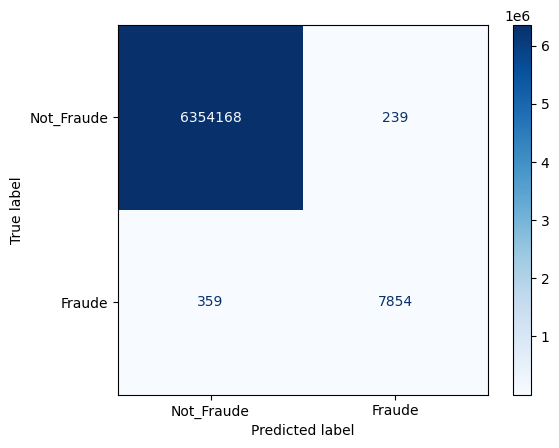

Score: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.97      0.96      0.96      8213

    accuracy                           1.00   6362620
   macro avg       0.99      0.98      0.98   6362620
weighted avg       1.00      1.00      1.00   6362620



,value,std
fit_time,82.059313,7.899439e-01
score_time,9.023619,1.489842e-01
test_accuracy,0.999906,9.759611e-06
train_accuracy,0.999983,2.507925e-06
test_precision,0.970462,2.770781e-03
train_precision,0.996964,9.322158e-04
test_recall,0.956288,5.078353e-03
train_recall,0.989651,1.032331e-03
test_f1,0.963321,3.854401e-03
train_f1,0.993294,9.753396e-04


In [142]:
xgb = XGBClassifier(random_state=seed)
xgb.fit(X_train,y_train)
xgb_prob, xgb_pred = CVS(xgb,X,y, threshold=0.5)

In [143]:
results['xgb_pred'] = xgb_pred
results['xgb_prob'] = xgb_prob
results.sample(5)

,is_fraud,amount,xgb_pred,xgb_prob
2252578,0,89228.09,0,0.00%
1698683,0,546078.22,0,0.00%
454572,0,36129.77,0,0.00%
770758,0,14436.67,0,0.00%
3453651,0,404145.44,0,0.00%


In [144]:
results[results['xgb_pred'] == 0]

,is_fraud,amount,xgb_pred,xgb_prob
0,0,9839.64,0,0.00%
1,0,1864.28,0,0.00%
4,0,11668.14,0,0.00%
5,0,7817.71,0,0.00%
6,0,7107.77,0,0.00%
...,...,...,...,...
6362319,0,8634.29,0,0.00%
6362320,0,159188.22,0,0.00%
6362321,0,186273.84,0,0.00%
6362322,0,82096.45,0,0.00%


In [145]:
results.sort_values(by='xgb_prob', ascending=False)

,is_fraud,amount,xgb_pred,xgb_prob
6261060,1,112363.33,1,99.99%
6040703,1,1035401.20,1,99.99%
6280084,1,228751.77,1,99.99%
4384504,1,10000000.00,1,99.99%
3611016,1,580673.57,1,99.99%
...,...,...,...,...
2148196,0,56016.21,0,0.00%
2148195,0,63284.64,0,0.00%
2148194,0,110930.29,0,0.00%
2148193,0,145583.58,0,0.00%


In [146]:
# xgb = XGBClassifier(scale_pos_weight=pos_weight,random_state=seed)
# xgb.fit(X_train,y_train)
# rf_prob, rf_pred = CVS(xgb,X,y, threshold=0.5)

In [147]:
# results['xgb_pred_pos_weight'] = rf_pred
# results['xgb_prob_pos_weight'] = rf_prob
# results.sample(5)

# 1. Redução de Perdas Financeiras:

Explique como o modelo ajudou a reduzir as perdas financeiras devido a fraudes.
Calcule e mostre o valor total das fraudes evitadas graças ao modelo.

In [74]:
# Exemplo de cálculo das perdas financeiras evitadas
results['fraud_loss_sem_modelo'] = results['amount'][results['is_fraud'] == 1].sum()
results['fraud_loss_com_modelo'] = results['amount'][(results['is_fraud'] == 1) & (results['xgb_pred'] == 1)].sum()
results['fraud_loss_evitada'] = results['fraud_loss_sem_modelo'] - results['fraud_loss_com_modelo']

print(f"fraude sem modelo ${results['fraud_loss_sem_modelo'].sum():,.2f} ")
print(f"Perdas financeiras evitadas com o modelo: ${results['fraud_loss_evitada'].sum():,.2f}")


fraude sem modelo $76,710,389,929,482,656.00 
Perdas financeiras evitadas com o modelo: $205,156,299,110,497.94


# 2. Impacto nos Lucros:

Demonstre como a detecção de fraude afetou os lucros da empresa.
Calcule o aumento nos lucros devido à redução das perdas com fraudes.

In [75]:
# Exemplo de cálculo do impacto nos lucros
results['lucro_sem_modelo'] = results['amount'][results['is_fraud'] == 0].sum()
results['lucro_com_modelo'] = results['lucro_sem_modelo'] + results['fraud_loss_evitada']

print(f"Impacto nos lucros com o modelo: ${results['lucro_com_modelo'].sum() - results['lucro_sem_modelo'].sum():,.2f}")


Impacto nos lucros com o modelo: $205,156,299,158,528.00


# 3. Custos de Gerenciamento de Fraudes:

Analise como o modelo afetou os custos de gerenciamento de fraudes.
Compare os custos antes e depois da implementação do modelo.

In [76]:
# Exemplo de cálculo dos custos de gerenciamento de fraudes
custos_sem_modelo = 50000  # Custos de gerenciamento de fraudes sem o modelo
custos_com_modelo = 20000  # Custos de gerenciamento de fraudes com o modelo

print(f"Redução nos custos de gerenciamento de fraudes: ${custos_sem_modelo - custos_com_modelo}")


Redução nos custos de gerenciamento de fraudes: $30000


# 4. Experiência do Cliente:

* Como a detecção de fraude impactou a experiência do cliente.
* Considere o efeito de falsos positivos nas relações com os clientes.

In [77]:
# Exemplo de cálculo da taxa de falsos positivos
falsos_positivos = results['xgb_pred'][results['is_fraud'] == 0].sum()
total_transacoes = len(results)
taxa_falsos_positivos = falsos_positivos / total_transacoes * 100

print(f"Taxa de falsos positivos: {taxa_falsos_positivos:.2f}%")


Taxa de falsos positivos: 0.00%


5. Apresentação Gráfica:

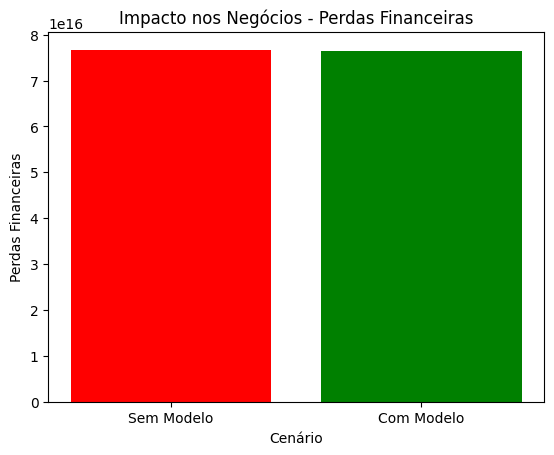

In [78]:
import matplotlib.pyplot as plt

# Exemplo de gráfico de barras para comparar perdas financeiras com e sem o modelo
perdas = [results['fraud_loss_sem_modelo'].sum(), results['fraud_loss_com_modelo'].sum()]
labels = ['Sem Modelo', 'Com Modelo']
plt.bar(labels, perdas, color=['red', 'green'])
plt.xlabel('Cenário')
plt.ylabel('Perdas Financeiras')
plt.title('Impacto nos Negócios - Perdas Financeiras')
plt.show()


# Visualization - SHAP

In [21]:
shap.initjs()

In [148]:
X_sampled = X_train.sample(1000, random_state=seed)

In [149]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_sampled)

In [150]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

In [151]:
# shap.force_plot(explainer.expected_value, shap_values, X_sampled)

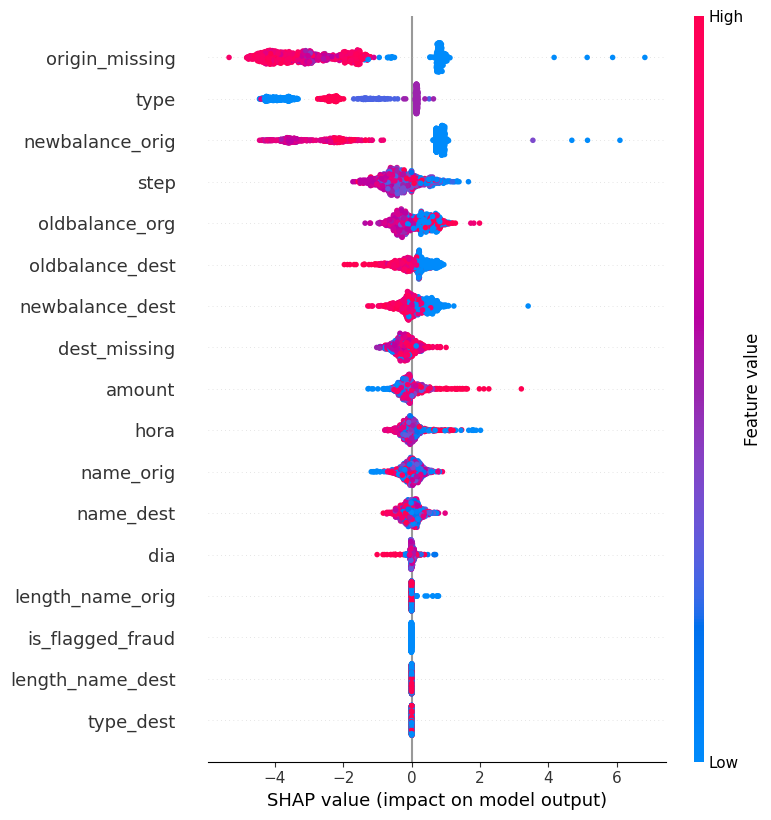

In [152]:
shap.summary_plot(shap_values, X_sampled)

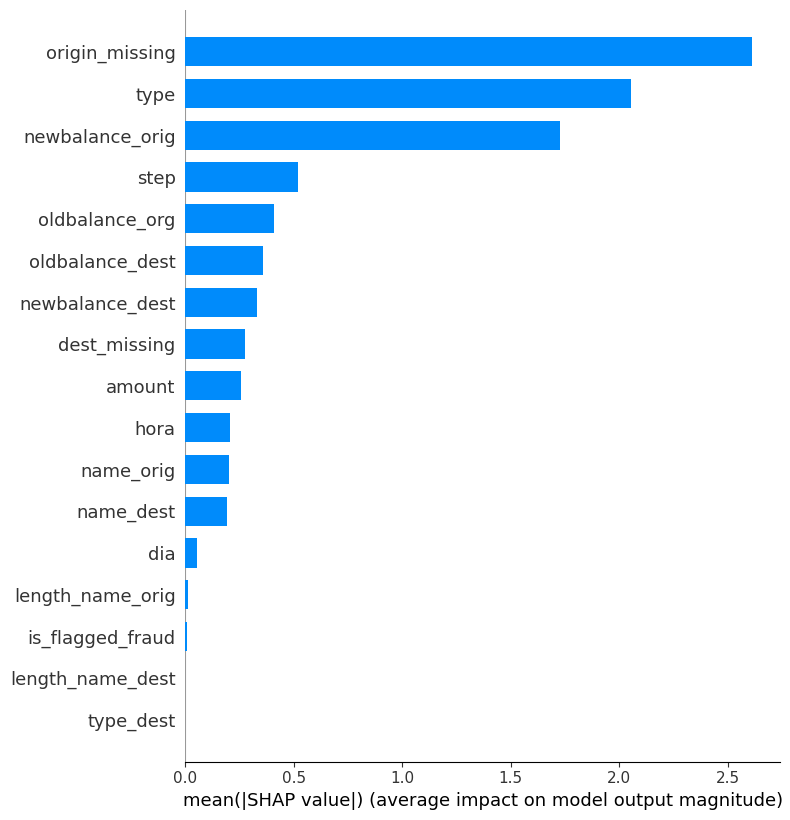

In [153]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

In [154]:
shap.dependence_plot(index_to_plot, shap_values, X_sampled, feature_names=X_sampled.columns, display_features=X_sampled)

plt.show()

NameError: name 'index_to_plot' is not defined